In [1]:
import os
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'
from IPython.display import Image

In [2]:
# !pip install --upgrade trl
# !pip install --upgrade bitsandbytes

In [3]:
import random
from typing import Dict, List
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)
from peft import (
    LoraConfig,
    PeftModel,
    TaskType,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from trl import DataCollatorForCompletionOnlyLM, SFTConfig, SFTTrainer

[2024-07-22 23:26:44,621] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [4]:
SEED = 42

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
seed_everything(SEED)

## overall

In [5]:
Image(url='https://www.mlexpert.io/_next/image?url=%2F_next%2Fstatic%2Fmedia%2Fbanner.2336875a.png&w=3840&q=75', width=500)

## constants

In [6]:
pad_token = "<|pad|>"
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
new_model = "Llama-3-8B-Instruct-Finance-RAG"

## model & tokenizer

In [7]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
# tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
tokenizer.special_tokens_map, tokenizer.pad_token

({'bos_token': '<|begin_of_text|>', 'eos_token': '<|end_of_text|>'}, None)

In [9]:
tokenizer.add_special_tokens({"pad_token": pad_token})
tokenizer.padding_side = "right"

In [10]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    #     attn_implementation="flash_attention_2",
    #     attn_implementation="sdpa",
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

We've detected an older driver with an RTX 4000 series GPU. These drivers have issues with P2P. This can affect the multi-gpu inference when using accelerate device_map.Please make sure to update your driver to the latest version which resolves this.


In [11]:
len(tokenizer.added_tokens_decoder)

257

In [12]:
model.model.embed_tokens, tokenizer.vocab_size, len(tokenizer)

(Embedding(128256, 4096), 128000, 128257)

In [13]:
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

Embedding(128264, 4096)

In [14]:
128257/8, 128264/8

(16032.125, 16033.0)

In [15]:
model.config

LlamaConfig {
  "_name_or_path": "meta-llama/Meta-Llama-3-8B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 8192,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
 

In [16]:
print(tokenizer.bos_token, tokenizer.bos_token_id)
print(tokenizer.eos_token, tokenizer.eos_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)

<|begin_of_text|> 128000
<|end_of_text|> 128001
<|pad|> 128256


## dataset

In [17]:
dataset = load_dataset("virattt/financial-qa-10K")

In [18]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'context', 'ticker', 'filing'],
        num_rows: 7000
    })
})

In [19]:
dataset['train'][:3]

{'question': ['What area did NVIDIA initially focus on before expanding to other computationally intensive fields?',
  'What are some of the recent applications of GPU-powered deep learning as mentioned by NVIDIA?',
  'What significant invention did NVIDIA create in 1999?'],
 'answer': ['NVIDIA initially focused on PC graphics.',
  'Recent applications of GPU-powered deep learning include recommendation systems, large language models, and generative AI.',
  'NVIDIA invented the GPU in 1999.'],
 'context': ['Since our original focus on PC graphics, we have expanded to several other large and important computationally intensive fields.',
  'Some of the most recent applications of GPU-powered deep learning include recommendation systems, which are AI algorithms trained to understand the preferences, previous decisions, and characteristics of people and products using data gathered about their interactions, large language models, which can recognize, summarize, translate, predict and gener

In [20]:
def process(row):
    return {
        "question": row["question"],
        "context": row["context"],
        "answer": row["answer"]
    }
new_dataset = dataset.map(process, num_proc=8, 
                          remove_columns=dataset["train"].column_names)
new_dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'context'],
        num_rows: 7000
    })
})

In [21]:
df = new_dataset['train'].to_pandas()
df.head()

,question,answer,context
0,What area did NVIDIA initially focus on before...,NVIDIA initially focused on PC graphics.,"Since our original focus on PC graphics, we ha..."
1,What are some of the recent applications of GP...,Recent applications of GPU-powered deep learni...,Some of the most recent applications of GPU-po...
2,What significant invention did NVIDIA create i...,NVIDIA invented the GPU in 1999.,Our invention of the GPU in 1999 defined moder...
3,How does NVIDIA's platform strategy contribute...,NVIDIA's platform strategy brings together har...,"NVIDIA has a platform strategy, bringing toget..."
4,What does NVIDIA's CUDA programming model enable?,NVIDIA's CUDA programming model opened the par...,With our introduction of the CUDA programming ...


In [22]:
df.isnull().value_counts()

question  answer  context
False     False   False      7000
Name: count, dtype: int64

### to chat dataset

In [23]:
from textwrap import dedent

In [24]:
row = df.iloc[0]

In [25]:
print(dedent(
    f"""
{row["question"]}

Information:

```
{row["context"]}
```
"""
))


What area did NVIDIA initially focus on before expanding to other computationally intensive fields?

Information:

```
Since our original focus on PC graphics, we have expanded to several other large and important computationally intensive fields.
```



In [26]:
def format_example(row: dict):
    prompt = dedent(
        f"""
    {row["question"]}

    Information:

    ```
    {row["context"]}
    ```
    """
    )
    messages = [
        {
            "role": "system",
            "content": "Use only the information to answer the question",
        },
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": row["answer"]},
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False)

In [27]:
df["text"] = df.apply(format_example, axis=1)

In [28]:
print(df.iloc[0]['text'])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

What area did NVIDIA initially focus on before expanding to other computationally intensive fields?

Information:

```
Since our original focus on PC graphics, we have expanded to several other large and important computationally intensive fields.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>

NVIDIA initially focused on PC graphics.<|eot_id|>


In [29]:
def count_tokens(row: Dict) -> int:
    return len(
        tokenizer(
            row["text"],
            add_special_tokens=True,
            return_attention_mask=False,
        )["input_ids"]
    )

In [30]:
df["token_count"] = df.apply(count_tokens, axis=1)

In [31]:
df.head()

,question,answer,context,text,token_count
0,What area did NVIDIA initially focus on before...,NVIDIA initially focused on PC graphics.,"Since our original focus on PC graphics, we ha...",<|begin_of_text|><|start_header_id|>system<|en...,75
1,What are some of the recent applications of GP...,Recent applications of GPU-powered deep learni...,Some of the most recent applications of GPU-po...,<|begin_of_text|><|start_header_id|>system<|en...,171
2,What significant invention did NVIDIA create i...,NVIDIA invented the GPU in 1999.,Our invention of the GPU in 1999 defined moder...,<|begin_of_text|><|start_header_id|>system<|en...,73
3,How does NVIDIA's platform strategy contribute...,NVIDIA's platform strategy brings together har...,"NVIDIA has a platform strategy, bringing toget...",<|begin_of_text|><|start_header_id|>system<|en...,97
4,What does NVIDIA's CUDA programming model enable?,NVIDIA's CUDA programming model opened the par...,With our introduction of the CUDA programming ...,<|begin_of_text|><|start_header_id|>system<|en...,83


In [32]:
# plt.hist(df.token_count, weights=np.ones(len(df.token_count)) / len(df.token_count))
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.xlabel("Tokens")
# plt.ylabel("Percentage")
# plt.show()

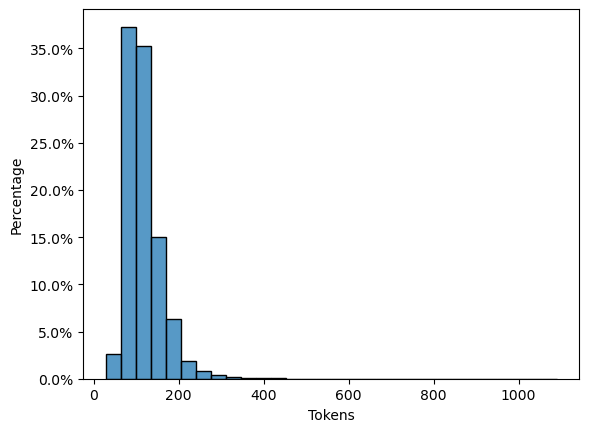

In [33]:
sns.histplot(df.token_count, stat='probability', bins=30)

# 设置 y 轴格式为百分比
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# 添加标签
plt.xlabel("Tokens")
plt.ylabel("Percentage")

# 显示图表
plt.show()

In [34]:
len(df[df.token_count < 512]), len(df), len(df[df.token_count < 512]) / len(df)

(6997, 7000, 0.9995714285714286)

In [35]:
# df = df[df.token_count < 512]
# df = df.sample(6000)
# df.shape

In [36]:
train, temp = train_test_split(df, test_size=0.2)
val, test = train_test_split(temp, test_size=0.2)

In [37]:
len(train), len(val), len(test)

(5600, 1120, 280)

In [38]:
len(train) / len(df), len(val) / len(df), len(test) / len(df)

(0.8, 0.16, 0.04)

In [39]:
train.sample(n=5000).to_json("./data/train.json", orient="records", lines=True)
val.sample(n=1000).to_json("./data/val.json", orient="records", lines=True)
test.sample(n=250).to_json("./data/test.json", orient="records", lines=True)

In [40]:
dataset = load_dataset(
    "json",
    data_files={"train": "./data/train.json", 
                "validation": "./data/val.json", 
                "test": "./data/test.json"},
)
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'context', 'text', 'token_count'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['question', 'answer', 'context', 'text', 'token_count'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['question', 'answer', 'context', 'text', 'token_count'],
        num_rows: 250
    })
})

## sft

### test on llama3-8b

In [41]:
pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=128,
    return_full_text=False,
)

In [42]:
def create_test_prompt(data_row):
    prompt = dedent(
        f"""
    {data_row["question"]}

    Information:

    ```
    {data_row["context"]}
    ```
    """
    )
    messages = [
        {
            "role": "system",
            "content": "Use only the information to answer the question",
        },
        {"role": "user", "content": prompt},
    ]
    return tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

In [43]:
row = dataset["test"][0]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

How does Amazon fulfill customer orders?

Information:

```
Amazon fulfills customer orders using its North America and International fulfillment networks, co-sourced and outsourced arrangements in certain countries, digital delivery, and physical stores.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [44]:
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)


answer:     Amazon fulfills customer orders through a combination of North America and International fulfillment networks operated by the company, co-sourced and outsourced arrangements in some countries, digital delivery, and through its physical stores.
prediction: According to the information, Amazon fulfills customer orders using:

1. North America and International fulfillment networks
2. Co-sourced and outsourced arrangements in certain countries
3. Digital delivery
4. Physical stores



In [45]:
row = dataset["test"][1]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

Who holds the patents for the active pharmaceutical ingredients of some of the company's products?

Information:

```
Patents covering certain of the active pharmaceutical ingredients ("API") of some of our products are held by third parties. We acquired exclusive rights to these patents in the agreements we have with these parties.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [46]:
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)


answer:     The patents for the active pharmaceutical ingredients of some of the company's products are held by third parties, from whom the company has acquired exclusive rights through agreements.
prediction: Third parties hold the patents for the active pharmaceutical ingredients of some of the company's products.



In [47]:
# rows = []
# for row in tqdm(dataset["test"]):
#     prompt = create_test_prompt(row)
#     outputs = pipe(prompt)
#     rows.append(
#         {
#             "question": row["question"],
#             "context": row["context"],
#             "prompt": prompt,
#             "answer": row["answer"],
#             "untrained_prediction": outputs[0]["generated_text"],
#         }
#     )

# predictions_df = pd.DataFrame(rows)

In [48]:
# np.arange(len(dataset["test"])) // 16

In [49]:
# batch_size = 64  # Adjust the batch size according to your GPU memory
# for batch in tqdm(dataset["test"].to_pandas().groupby(np.arange(len(dataset["test"])) // batch_size)):
#     batch_df = batch[1]
#     prompts = batch_df.apply(create_test_prompt, axis=1).tolist()
#     outputs = pipe(prompts)

#     for i, output in enumerate(outputs):
#         # print(output)
#         rows.append(
#             {
#                 "question": batch_df.iloc[i]["question"],
#                 "context": batch_df.iloc[i]["context"],
#                 "prompt": prompts[i],
#                 "answer": batch_df.iloc[i]["answer"],
#                 "untrained_prediction": output[0]["generated_text"],
#             }
#         )

# predictions_df = pd.DataFrame(rows)

### Train on Completions

- collate_fn
    - DataCollatorForCompletionOnlyLM

In [50]:
examples = [dataset["train"][0]["text"]]
print(examples[0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

Who is the Chief Financial Officer and since when?

Information:

```
Richard A. Galanti | Executive Vice President and Chief Financial Officer. Mr. Galanti has been a director since January 1995.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Richard A. Galanti is the Executive Vice President and Chief Financial Officer, and he has been in this role since 1993.<|eot_id|>


In [51]:
response_template = "<|end_header_id|>"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)
# collator

In [52]:
encodings = [tokenizer(e) for e in examples]
dataloader = DataLoader(encodings, collate_fn=collator, batch_size=1)

In [53]:
batch = next(iter(dataloader))
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [54]:
batch["input_ids"]

tensor([[128000, 128006,   9125, 128007,    271,  10464,   1193,    279,   2038,
            311,   4320,    279,   3488, 128009, 128006,    882, 128007,    271,
          15546,    374,    279,  14681,  17961,  20148,    323,   2533,    994,
           1980,  15218,   1473,  14196,   4077,  42315,    362,     13,  10845,
          15719,    765,  18362,  23270,   4900,    323,  14681,  17961,  20148,
             13,   4491,     13,  10845,  15719,    706,   1027,    264,   7690,
           2533,   6186,    220,   2550,     20,    627,  74694, 128009, 128006,
          78191, 128007,    271,  42315,    362,     13,  10845,  15719,    374,
            279,  18362,  23270,   4900,    323,  14681,  17961,  20148,     11,
            323,    568,    706,   1027,    304,    420,   3560,   2533,    220,
           2550,     18,     13, 128009]])

In [55]:
batch["labels"]

tensor([[  -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,    271,  42315,    362,     13,  10845,  15719,    374,
            279,  18362,  23270,   4900,    323,  14681,  17961,  20148,     11,
            323,    568,    706,   1027,    304,    420,   3560,   2533,    220,
           2550,     18,     13, 128009]])

In [56]:
tokenizer.decode([271,   9390,   5961,    323,  39543, 128009])

'\n\n126 countries and territories<|eot_id|>'

### lora setup

In [57]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128264, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Ll

In [58]:
lora_config = LoraConfig(
    r=32,
    lora_alpha=16,
    target_modules=[
        "self_attn.q_proj",
        "self_attn.k_proj",
        "self_attn.v_proj",
        "self_attn.o_proj",
        "mlp.gate_proj",
        "mlp.up_proj",
        "mlp.down_proj",
    ],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

In [59]:
model.print_trainable_parameters()

trainable params: 83,886,080 || all params: 8,114,212,864 || trainable%: 1.0338166055782685


### sft train

In [60]:
output_dir = "experiments"

# ssh -L 6006:localhost:6006 user@remote_server
# localhost:6006
%load_ext tensorboard
%tensorboard --logdir "experiments/runs"

In [61]:
os.environ["NCCL_P2P_DISABLE"] = "1"
os.environ["NCCL_IB_DISABLE"] = "1"

In [62]:
dataset["train"]

Dataset({
    features: ['question', 'answer', 'context', 'text', 'token_count'],
    num_rows: 5000
})

In [63]:
# global_step=156
5000/32

156.25

In [64]:
# eval_steps=0.2,
len(dataset['train']) / (8*4) * .2, len(dataset['validation']) / 8,
# save_steps=0.2, save_total_limit=2,
# checkpoint-32-64-96-128-256

(31.25,)

In [66]:
sft_config = SFTConfig(
    output_dir=output_dir,
    dataset_text_field="text",
    max_seq_length=512,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    optim="paged_adamw_8bit",
    eval_strategy="steps",
    eval_steps=0.2,
    save_steps=0.2,
    logging_steps=10,
    learning_rate=1e-4,
    fp16=True,  # or bf16=True,
    save_strategy="steps",
    warmup_ratio=0.1,
    save_total_limit=2,
    lr_scheduler_type="constant",
    report_to="tensorboard",
    save_safetensors=True,
    dataset_kwargs={
        "add_special_tokens": False,  # We template with special tokens
        "append_concat_token": False,  # No need to add additional separator token
    },
    seed=SEED,
)

trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [67]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/home/whaow/anaconda3/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
32,0.512600,0.512450
64,0.444700,0.498785
96,0.430900,0.492569
128,0.472300,0.485446


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
/home/whaow/anaconda3/lib/python3.10/site-packages/peft/utils/other.py:581: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-669e7b35-27a2c8f44da566482a12bf90;e2617a9b-85a5-40ae-a456-cf9a99a3be54)

Cannot access gated repo for url https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct/resolve/main/config.json.
Access to model meta-llama/Meta-Llama-3-8B-Instruct is restricted. You must be authenticated to access it. - silently ignoring the lookup for the file config.json in meta-llama/Meta-Llama-3-8B-Instruct.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in meta-llama/Meta-Llama-3-

TrainOutput(global_step=156, training_loss=0.48717997929988766, metrics={'train_runtime': 932.358, 'train_samples_per_second': 5.363, 'train_steps_per_second': 0.167, 'total_flos': 4.268560560979968e+16, 'train_loss': 0.48717997929988766, 'epoch': 0.9984})

In [ ]:
trainer.save_model(new_model)